# Grid Search - Como encontrar os melhores hiper-parâmetros?

O GridSearch permite rodar um mesmo modelo com hyperparâmetros diferentes, e automaticamente, encontrar os melhores hiperparâmetros para uma dada métrica (*recall, precision, accuracy, f1-score e etc*)

Links
+ Para que serve gridSearch
  - https://gusrabbit.com/code/grid-search/
+ Tuning Hyperparameters
  - https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
file_path = "../files/"

### PréProcessamento

In [3]:
# Importing the dataset
dataset = pd.read_csv(file_path + 'Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
y = dataset.iloc[:, 4].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Classificador  `SVM`

In [4]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [5]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[64,  4],
       [ 3, 29]])

### Aplicando com CrossValidation

In [8]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

# Métricas do CrossValidation
print("qtd tests:", len(accuracies))
print("mean:", accuracies.mean())
print("std:", accuracies.std())

qtd tests: 10
mean: 0.9033333333333333
std: 0.06574360974438671


### Aplicando `GridSearch` para buscar os melhores `hyperParams`

Grid Search é uma técnica para fazer cross validation em vários modelos com hiperparâmetros diferentes de uma vez. e Assim escolher quais são os melhores hiperparâmetros


Assinatura do GridSearch

````python
GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=1, iid=True, refit=True, cv=None, 
             verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise’, return_train_score=’warn’)
````

Desse parâmetros o mais importante são

`estimator`: O classificador a ser testado

`param_grid`: Uma lista ou dicionário contendo diversos `hiperParâmetros` para testar

`scoring`: qual a métrica para escolher a melhor combinaçâo de `hiperParâmetros`

`cv`: Número do CrossValidation. Por exemplo, se escolher 10 (número usado para artigos científicos), então, ele vai dividir a base em 10 partes, pegar 9 para treinar e 1 para testar. Faz isso 10 vezes variando a parte que é de teste.

`n_jobs`: Número de Jobs para serem rodados em paralelo. Sem geral é 1 (sem paralelismo). Se quiser usar todos os processadores, coloque -1.

`verbose`: se vai printar alguns dados ou não na tela. É um número inteiro. Se 0, nâo mosra nada, e a meidda que cresce motra mais dados enquanto faz o processo.

---

Lembrando que dependendo do que vai fazer (Classificação, Regressão ou Clusterização) muda o parÂmetro de  `scoring`. Olhe o link:

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

---

**Quais são os parâmetros do meu classificado?**

Utilize a trecho a seguir:
    
````python
classifier.get_params().keys()
````

Para retorna uma lista de todos os parâmetros que podem ser configurados para o seu classificador.

Após isso, é necessário entendêlos e então escolher os mehlores e buscar bons valores para testar.

In [18]:
# Parâmetros do SVC - C-Support Vector Classification
classifier.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

**Como estamos trabalhando com o SVC, vamos escolher os seguintes hiperparâmetros**

+ `C` :: float, optional (default=1.0)

Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

+ `kernel` :: string, optional (default=’rbf’)

Specifies the kernel type to be used in the algorithm. It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. If none is given, ‘rbf’ will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape `(n_samples, n_samples)`.

+ `gamma` :: {‘scale’, ‘auto’} or float, optional (default=’scale’)

Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

+ if gamma='scale' (default) is passed then it uses `1 / (n_features * X.var())` as value of gamma,
+ if ‘auto’, uses `1 / n_features`.

In [ ]:
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 
                   'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [9]:
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
# Fit GridSearch
grid_search = grid_search.fit(X_train, y_train)

In [10]:
# Melhor Accuray dos testes
best_accuracy = grid_search.best_score_
best_accuracy

0.9066666666666666

In [11]:
# Melhores HiperParâmetros encontrados para a métrica 'accuracy'
best_parameters = grid_search.best_params_
best_parameters

{'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}

### Analisando resultado do `GridSearch` em um `DataFrame`

In [16]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005435,0.002261,0.001409,0.000455,1,linear,NaN,"{'C': 1, 'kernel': 'linear'}",0.766667,0.800000,...,0.833333,0.733333,0.666667,0.833333,0.933333,0.966667,0.866667,0.813333,0.088443,40
1,0.008198,0.002225,0.001844,0.002265,10,linear,NaN,"{'C': 10, 'kernel': 'linear'}",0.800000,0.800000,...,0.833333,0.733333,0.666667,0.833333,0.933333,0.966667,0.900000,0.820000,0.089691,39
2,0.026942,0.005250,0.001030,0.000039,100,linear,NaN,"{'C': 100, 'kernel': 'linear'}",0.800000,0.866667,...,0.833333,0.733333,0.666667,0.833333,0.933333,0.966667,0.900000,0.826667,0.090431,37
3,0.201494,0.052907,0.001017,0.000062,1000,linear,NaN,"{'C': 1000, 'kernel': 'linear'}",0.800000,0.866667,...,0.833333,0.733333,0.666667,0.833333,0.933333,0.966667,0.900000,0.826667,0.090431,37
4,0.004893,0.000309,0.001109,0.000047,1,rbf,0.1,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.833333,0.933333,...,0.900000,0.833333,0.866667,0.900000,0.933333,1.000000,0.933333,0.896667,0.052599,21
5,0.004824,0.000863,0.001335,0.000862,1,rbf,0.2,"{'C': 1, 'gamma': 0.2, 'kernel': 'rbf'}",0.833333,0.933333,...,0.933333,0.833333,0.866667,0.900000,0.933333,1.000000,0.933333,0.900000,0.053748,10
6,0.005243,0.002423,0.001026,0.000071,1,rbf,0.3,"{'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}",0.833333,0.933333,...,0.933333,0.833333,0.866667,0.900000,0.933333,1.000000,0.933333,0.900000,0.053748,10
7,0.005712,0.001895,0.001026,0.000020,1,rbf,0.4,"{'C': 1, 'gamma': 0.4, 'kernel': 'rbf'}",0.800000,0.966667,...,0.966667,0.833333,0.866667,0.900000,0.933333,1.000000,0.933333,0.903333,0.064031,5
8,0.005477,0.002145,0.001081,0.000042,1,rbf,0.5,"{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}",0.800000,0.966667,...,0.966667,0.866667,0.866667,0.900000,0.933333,1.000000,0.933333,0.903333,0.065744,5
9,0.006001,0.002886,0.001180,0.000103,1,rbf,0.6,"{'C': 1, 'gamma': 0.6, 'kernel': 'rbf'}",0.800000,0.966667,...,0.966667,0.866667,0.866667,0.900000,0.933333,1.000000,0.933333,0.903333,0.065744,5


### Gráficos

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


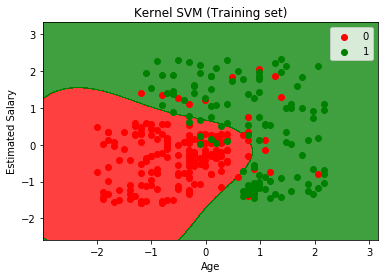

In [12]:
# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


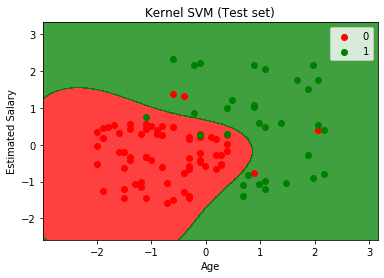

In [13]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('Kernel SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

### SVC Com HyperPrametros Tunados

````python
{'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}
````

In [55]:
# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', C = 1, gamma = 0.7)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# CrossValidation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)

# Métricas do CrossValidation
print("mean:", accuracies.mean())
print("std:", accuracies.std())

mean: 0.9066666666666666
std: 0.06798692684790378


#### Conclusão Comparando 

|  Modelo/Métrica | Média | DesvioPadrão |
| --- | --- | --- |
| Sem Tuning | 0.9033333333333333 | 0.06574360974438671 |
| Com Tunnig | 0.9066666666666666 | 0.06798692684790378 |



## Outro Exemplo de GridSearch com RandomForest

In [20]:
from sklearn.ensemble import RandomForestClassifier
classify = RandomForestClassifier()
classify.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [30]:
param_grids = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 4, 6, 8]}

In [31]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = classify,
                           param_grid = param_grids,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)

In [32]:
# Melhor Accuray dos testes
best_accuracy = grid_search.best_score_
best_accuracy

0.9066666666666666

In [33]:
# Melhores HiperParâmetros encontrados para a métrica 'accuracy'
best_parameters = grid_search.best_params_
best_parameters

{'criterion': 'gini', 'max_depth': 2}

In [34]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.418333,0.010753,0.031237,0.003106,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.883333,0.850000,0.900000,0.916667,0.983333,0.906667,0.044222,1
1,0.412080,0.005173,0.030843,0.002879,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.883333,0.833333,0.850000,0.916667,0.983333,0.893333,0.053333,4
2,0.434209,0.012428,0.029985,0.001026,gini,6,"{'criterion': 'gini', 'max_depth': 6}",0.883333,0.850000,0.850000,0.900000,0.983333,0.893333,0.048990,4
3,0.424051,0.006280,0.029878,0.000852,gini,8,"{'criterion': 'gini', 'max_depth': 8}",0.900000,0.850000,0.816667,0.933333,0.966667,0.893333,0.054365,4
4,0.420223,0.035567,0.029367,0.000902,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.883333,0.850000,0.850000,0.916667,0.983333,0.896667,0.049889,3
5,0.496664,0.070684,0.033940,0.009782,entropy,4,"{'criterion': 'entropy', 'max_depth': 4}",0.883333,0.850000,0.866667,0.916667,0.983333,0.900000,0.047140,2
6,0.473675,0.024701,0.032503,0.000979,entropy,6,"{'criterion': 'entropy', 'max_depth': 6}",0.866667,0.833333,0.850000,0.916667,0.933333,0.880000,0.038586,7
7,0.485854,0.017310,0.029643,0.009468,entropy,8,"{'criterion': 'entropy', 'max_depth': 8}",0.883333,0.850000,0.800000,0.933333,0.933333,0.880000,0.050990,7


## Testando Outro `GridSearch` com outros parâmetros

In [36]:
# HyperParams
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit GridSearch
grid_search = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  9.3min finished


In [37]:
# Melhor Accuray dos testes
best_accuracy = grid_search.best_score_
best_accuracy

0.9033333333333333

In [38]:
# Melhores HiperParâmetros encontrados para a métrica 'accuracy'
best_parameters = grid_search.best_params_
best_parameters

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300}

In [40]:
(pd.DataFrame(grid_search.cv_results_)).sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
221,1.428169,0.079968,0.104131,0.009526,True,110,2,3,10,200,"{'bootstrap': True, 'max_depth': 110, 'max_fea...",0.86,0.89,0.96,0.903333,0.041899,1
94,1.970805,0.067993,0.167306,0.021278,True,90,2,4,12,300,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",0.86,0.89,0.96,0.903333,0.041899,1
101,1.360007,0.044134,0.100131,0.008010,True,90,2,5,10,200,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",0.86,0.89,0.96,0.903333,0.041899,1
104,0.891148,0.137796,0.072599,0.013369,True,90,2,5,12,100,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",0.86,0.89,0.96,0.903333,0.041899,1
105,1.999099,0.087178,0.135247,0.006792,True,90,2,5,12,200,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",0.86,0.89,0.96,0.903333,0.041899,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.509006,0.004484,0.000000,0.000000,True,90,3,5,8,200,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",NaN,NaN,NaN,NaN,NaN,284
134,0.822045,0.005041,0.000000,0.000000,True,90,3,5,8,300,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",NaN,NaN,NaN,NaN,NaN,285
135,2.992940,0.093607,0.000000,0.000000,True,90,3,5,8,1000,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",NaN,NaN,NaN,NaN,NaN,286
137,0.703232,0.084939,0.000000,0.000000,True,90,3,5,10,200,"{'bootstrap': True, 'max_depth': 90, 'max_feat...",NaN,NaN,NaN,NaN,NaN,287


### Sem HyperPrams Tuning

In [47]:
from sklearn.ensemble import RandomForestClassifier
base_classify = RandomForestClassifier()

In [48]:
base_classify.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [53]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = base_classify, X = X_train, y = y_train, cv = 10)

# Métricas do CrossValidation
print("mean:", accuracies.mean())
print("std:", accuracies.std())

qtd tests: 10
mean: 0.8966666666666667
std: 0.05666666666666666


### Aplicando parâmetros de `tuning`

Foi encontrado os seguintes parâmetros

````python
{
 'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 300
}
````

In [54]:
from sklearn.ensemble import RandomForestClassifier

# Classifier with HyperParameters Tuning
base_classify = RandomForestClassifier(
    bootstrap = True, max_depth = 80, max_features = 2, min_samples_leaf = 3, min_samples_split = 10, n_estimators = 300)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = base_classify, X = X_train, y = y_train, cv = 10)

# Métricas do CrossValidation
print("mean:", accuracies.mean())
print("std:", accuracies.std())

qtd tests: 10
mean: 0.9
std: 0.07149203529842404


### Conclusão

Conseguimos aumentar bem pouco, ao custo de maior desvio padrão


|  Modelo/Métrica | Média | DesvioPadrão |
| --- | --- | --- |
| Sem Tuning | 0.8966666666666667 | 0.05666666666666666 |
| Com Tunnig | 0.90 | 0.07149203529842404 |